In [1]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime 

from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style('white')
%matplotlib inline

import pickle

from sklearn import mixture
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM

from sklearn.cross_validation import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.preprocessing import scale
from sklearn import cross_validation

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
dbfile = 'project_july26.db' # only project_july26.db has up-to-date word feats
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?

In [3]:
platform = 'tw' # ig = instagram, tw = twitter
condition = 'depression' # depression, pregnancy, ptsd, cancer

In [4]:
specs = analysis_specifications(platform, condition)

platform_long = specs['plong'][platform]
gb_types = specs['gb_types'][platform]
fields = specs['fields'][platform] 
test_name = specs['test_name'][condition]
test_cutoff = specs['test_cutoff'][condition]
photos_rated = specs['photos_rated'][condition]
has_test = specs['has_test'][condition]

clfs = ['rf'] # lr = logistic regression, rf = random forests, svc = support vector
periods = ['before','after']
turn_points = ['from_diag','from_susp']

impose_test_cutoff = True # do we want to limit target pop based on testing cutoff (eg. cesd > 21)?

limit_date_range = False # do we want to restrict posts by date range? 

posting_cutoff = False # Drops usernames with fewer than (mean - 0.5std) total posts (for mcmc p-val improvement)

additional_data = True # for instagram, do we also get photo ratings? (This is proxy for limit_date_range in places)

include_filter = False # (instagram only) include binary indicator of filter use? 

include_face_data = False # (instagram only) include has_face and face_ct? 

report_sample_size = False # simple reporting feature for sample size

report_sm_disq = False # reports #/% of subjects disqualified for refusing to share social media data

get_ratings_correlation = False # (instagram-only) gets inter-rater correlation averages for each rated variable 

load_from = 'file' # None, file, pickle :: loads masters from pickled file, or just masters from csv
write_to_pickle = False # writes initial data (prepare_raw_data()) to pickle file
final_pickle = False # pickles entire data dict after all masters are created

populate_wordfeats_db = False # generates word features from reagan code (twitter only)

compare_ig_filters = False # (nstagram only) compares use of filters between target and control pops

make_hourly_plot = False # make plot of aggregated hourly posting for target vs control?

run_master = True 
run_subsets = True
run_separate_pca = False
run_kalman = True 
run_gmm = True

load_kalman = True
kalman_iter = 100
gmm_perm_iter = 1000

action_params = {
    'create_master': True, 
    'save_to_file' : True, 
    'density' : False, 
    'ml' : False, 
    'nhst' : False, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': True,
    'acc_avg': 'binary',
    'rf_n_est': 100
}

params = define_params(condition, test_name, test_cutoff, impose_test_cutoff,
                       platform, platform_long, fields, photos_rated, has_test, additional_data)

## Load data

Load a separate entry for each groupby 

In [5]:
if load_from == 'pickle':
    data = pickle.load( open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "rb" ) )
    
elif load_from == 'file':

else:
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, 
                     periods, turn_points, posting_cutoff,
                     additional_data=additional_data, include_filter=include_filter, limit_date_range=limit_date_range)
    if write_to_pickle:
        pickle.dump( data, open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "wb" ) )
    

TARGET DATA:
Number of tweets with url in text: 0
Adding url tags...
Number of tweets with url in text: 43557
Adding reply tags...
Number of tweets with @ in text: 89391
Adding RT tags...
Number of tweets with RT: 38669

('Subset shape for TW BEFORE FROM_DIAG:', (59293, 15))
('Subset shape for TW BEFORE FROM_SUSP:', (18271, 15))
('Subset shape for TW AFTER FROM_DIAG:', (104925, 15))
('Subset shape for TW AFTER FROM_SUSP:', (27389, 15))

CONTROL DATA:
Number of tweets with url in text: 0
Adding url tags...
Number of tweets with url in text: 37571
Adding reply tags...
Number of tweets with @ in text: 57791
Adding RT tags...
Number of tweets with RT: 19555



In [6]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'
    
    if action_params['create_master']:
        master['model'] = {}

    for gb_type in gb_types:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs, additional_data, posting_cutoff)


Merge to master: MAIN created_date
master created_date shape: (102215, 88)


Merge to master: MAIN weekly
master weekly shape: (29328, 86)


Merge to master: MAIN user_id
master user_id shape: (394, 78)



In [12]:
data = {}
when = "MAIN"
datetype = ""#_from_diag"
addtl = "no_addtl_data"
cut = "post_uncut"

gb_types = ['created_date']
for gbt in gb_types: 
    fdir = '/'.join(["data-files",condition,platform,gbt])
    fname = '_'.join([condition,platform,gbt,when+datetype,addtl,cut])
    fname = fname+'.csv'
    fpath = '/'.join([fdir,fname])
    data[gbt] = pd.read_csv(fpath)

    if platform == 'tw': # why do we drop the first column for tw data?  coming back to it with ig it doesn't seem right
        data[gbt].drop(data[gbt].columns[0], 1, inplace=True) # drops index

IOError: File data-files/depression/tw/created_date/depression_tw_created_date_MAIN_no_addtl_data_post_uncut.csv does not exist

## Set up training data

In [452]:
target = 'target'

if platform == 'ig':
    user = 'username'
elif platform == 'tw':
    user = 'user_id'
    
means = 'means'

In [453]:
gb_type = 'created_date'
mdf = data['master'][gb_type].copy()

predictors = params['vars'][platform][gb_type][means]

X = mdf[predictors].copy()

In [454]:
## this section for kalman filter only.  the user_id thing doesn't work for instagram...
if run_kalman or run_gmm:
    gb_type = 'created_date'
    mdf = data['master'][gb_type].copy()

    if platform == 'tw':
        # this mask isn't exhaustive...but it is meant to cover cases where tweets just don't give much useful info
        equals_zero_mask = (mdf.LabMT_happs != 0) & (mdf.ANEW_happs != 0)
        mdf = mdf.loc[equals_zero_mask]

    tpop = mdf.ix[mdf.target==1,:]
    cpop = mdf.ix[mdf.target==0,:]

    print 'Num target ids:', tpop[user].unique().shape
    print 'Num control ids:', cpop[user].unique().shape

    # you should fix this up a bit...the reason you're sampling by user_id and not with a normal train_test_split is so you
    # can take the class assignments and plot them on a time series for the entire span of a given subject
    # still that's a bit messy and also not very principled with the numbers you picked.
    Tuid_train = pd.Series(tpop[user].unique()).sample(70)
    Cuid_train = pd.Series(cpop[user].unique()).sample(80)
    uid_train = pd.concat([Tuid_train,Cuid_train]).values

    df_train = mdf.ix[mdf[user].isin(uid_train),:]
    df_test = mdf.ix[~mdf[user].isin(uid_train),:]

    predictors = params['vars'][platform][gb_type][means]

    X = mdf[predictors].copy()
    X_train = df_train[predictors].copy()
    X_test = df_test[predictors].copy()
    y_train = df_train[target]
    y_test = df_test[target]

    df_to_use = X

Num target ids: (105,)
Num control ids: (99,)


## Kalman Filter

Note that default settings seem to specify a single-variate Gaussian for the latent variable.  You may want to adjust this.

In [14]:
if load_kalman:
    kalman_df = pd.read_csv('{cond}_{pl}_{gb_type}_KF_MAIN.csv'.format(cond=condition, pl=platform, gb_type=gb_type))
    kfmeans = kalman_df.kf_mean
    kfcov = kalman_df.kf_cov
else:
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=X.shape[1])
    
    kf.em(X, n_iter=kalman_iter) # running on depression/tw/weekly this takes about 30 min with n_iter=100
    
    kfout = kf.smooth(df_to_use)
    kfmeans = kfout[0]
    kfcov = kfout[1]
    
    #save to file
    (pd.DataFrame({'kf_mean':kfout[0].ravel(), 'kf_cov':kfout[1].ravel()}, index=X.index)
       .to_csv('{cond}_{pl}_{gb_type}_KF_MAIN.csv'.format(cond=condition, pl=platform, gb_type=gb_type), index=False)
     )
    
df_to_use['kf_mean'] = kfmeans
df_to_use['kf_cov'] = kfcov.ravel()
df_to_use['user_id'] = mdf.user_id[df_to_use.index]
df_to_use['target'] = mdf.target[df_to_use.index]
df_to_use['diag_date'] = mdf.diag_date[df_to_use.index]
df_to_use['created_date'] = mdf.created_date[df_to_use.index]
df_to_use['from_diag'] = mdf.from_diag[df_to_use.index]

In [291]:
# are kf_means correlated with any other variables?

corr_thresh = 0.03

print 'Correlation threshold:', corr_thresh
print
for col in df_to_use.columns:
    if col not in ['kf_mean','user_id','diag_date','created_date']:
        try:
            corr = pearsonr(df_to_use[col], df_to_use.kf_mean)
            if abs(corr[0]) > corr_thresh:
                print col, '::', round(corr[0], 3), '(p={})'.format(round(corr[1], 3))
        except:
            print
            print 'FAIL:', col

Correlation threshold: 0.03

total_words :: -0.031 (p=0.0)
LabMT_happs :: -0.032 (p=0.0)
LIWC_health :: -0.041 (p=0.0)
LIWC_achieve :: -0.031 (p=0.0)
tweet_count :: -0.034 (p=0.0)


In [289]:
# check if Kalman means are different between target/control

rolled_ttest = False # do you want the t-test to use rolling means of kf_mean?
ttest_roll = 90

a = df_to_use.ix[df_to_use.target==1,'kf_mean']
b = df_to_use.ix[df_to_use.target==0,'kf_mean']

if rolled_ttest:
    a = a.rolling(ttest_roll).mean().dropna()
    b = b.rolling(ttest_roll).mean().dropna()
    
test = ttest(a, b)


print 'Depressed Kalman mean: {} (sd={})'.format(round(a.mean(), 3), round(a.std(), 3))
print 'Control Kalman mean: {} (sd={})'.format(round(b.mean(), 3), round(b.std(), 3))
print
print 't = {}, p = {}'.format(test.statistic,test.pvalue)
print 
print '(Rolling mean window: {} days)'.format(roll2)

Depressed Kalman mean: 47.301 (sd=16.607)
Control Kalman mean: 47.473 (sd=15.355)

t = -1.41530298507, p = 0.156984161457

(Rolling mean window: 90 days)


In [307]:
# set rolling window for computing time series stats
roll = 30

# variable of interest
target = 'kf_mean'

In [308]:
# target class

dff = df_to_use.reset_index(drop=True)
ct = 0
color_ct = 0
uct = 0
last_uid = ''
colors = ['blue','purple','green','orange','pink','maroon','cyan']

master_t = pd.DataFrame()

for idx in dff.ix[(dff.target==1) & dff[target].notnull(),:].index:
    uid = dff.ix[idx,'user_id']
    if uid != last_uid:
        ct += 1
        last_uid = uid
        diag = pd.to_datetime(dff.ix[idx,'diag_date'])
        oneuser = dff.ix[dff.user_id==uid, :].copy()

        ts = oneuser.ix[:,[target,'from_diag']].copy()
        ts['from_point'] = ts.from_diag
        ts.index = pd.to_datetime(oneuser.created_date)


        mask = (ts.index > diag-pd.DateOffset(365)) & (ts.index < diag+pd.DateOffset(365))
        #ts2 = ts.ix[mask,'kf_mean'].copy()
        ts['rmean'] = ts[target].rolling(roll).mean()
        ts2 = ts.loc[mask]
        master_t = pd.concat([master_t,ts2])
        #print ts2.head(20)
        #ax = ts.plot(style='-')
        #plt.plot(ts2.from_diag, ts2.rmean, colors[color_ct], alpha=0.3)
        #plt.axvline(x=0, color='red')
        #color_ct = ct % 4
        #plt.xlim([diag-pd.DateOffset(365), diag+pd.DateOffset(365)])

In [309]:
# control class

ct = 0
color_ct = 0
uct = 0
last_uid = ''
colors = ['blue','purple','green','orange','pink','maroon','cyan']

master_c = pd.DataFrame()

for idx in dff.ix[(dff.target==0) & dff[target].notnull(),:].index:

    uid = dff.ix[idx,'user_id']
    if uid != last_uid:
        ct += 1
        last_uid = uid
        current = pd.to_datetime('2016-04-01')

        oneuser = dff.ix[dff.user_id==uid, :].copy()

        ts = oneuser.ix[:,[target,'created_date','LabMT_happs']].copy()
        ts.index = pd.to_datetime(oneuser.created_date)
        ts['from_point'] = (ts.index-current).days
        mask = (ts.from_point > -365*2)

        ts['rmean'] = ts[target].rolling(roll).mean()
        ts2 = ts.loc[mask]
        master_c = pd.concat([master_c, ts2])
        
        #ax = ts.plot(style='-')
        #plt.plot(ts2.from_current, ts2.rmean, colors[color_ct], alpha=0.3)
        #plt.axvline(x=0, color='red')
        #plt.ylim([-20,120])
        #color_ct = ct % 4
        #plt.xlim([diag-pd.DateOffset(365), diag+pd.DateOffset(365)])


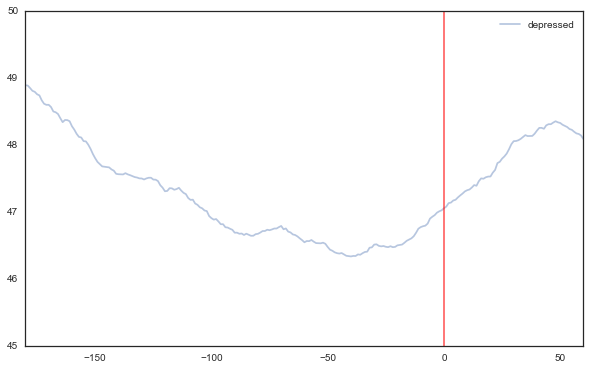

In [310]:
master_t['target'] = 'depressed'
master_c['target'] = 'control'
tsdf = pd.concat([master_t,master_c])

tsgb = tsdf.groupby(['target','from_point']).agg({'rmean':['mean','var'],
                                                  'LabMT_happs':'mean'})
new_colname = ['%s%s' % (a, '|%s' % b if b else '') for a, b in tsgb.columns]
tsgb.columns = new_colname

tsgb2 = tsgb.reset_index()

t_rm = tsgb2.ix[tsgb2.target=='depressed','rmean|mean'].rolling(roll2).mean()
t_from = tsgb2.ix[tsgb2.target=='depressed','from_point']
c_rm = tsgb2.ix[tsgb2.target=='control','rmean|mean'].rolling(roll2).mean()
c_from = tsgb2.ix[tsgb2.target=='control','from_point']

plt.figure(figsize=(10,6))
plt.plot(t_from, t_rm, alpha=.4, label='depressed')
plt.xlim([-180, 60])
#plt.plot(c_from, c_rm, alpha=.4, label='control')
plt.axvline(x=0, color='red', alpha=0.6)
plt.legend()

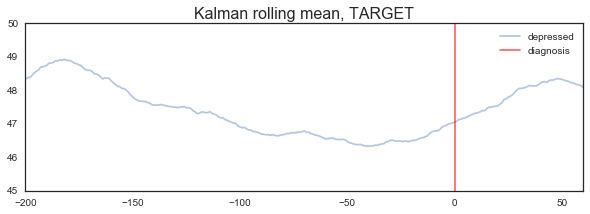

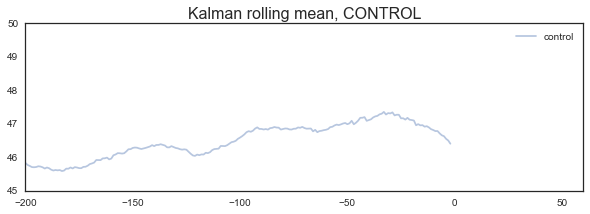

In [312]:
# tsgb = time series group-by

tsgb2 = tsgb.reset_index()

t_rm = tsgb2.ix[tsgb2.target=='depressed','rmean|mean'].rolling(roll2).mean()

t_from = tsgb2.ix[tsgb2.target=='depressed','from_point']
c_rm = tsgb2.ix[tsgb2.target=='control','rmean|mean'].rolling(roll2).mean()
c_happs = tsgb2.ix[tsgb2.target=='control','LabMT_happs|mean'].rolling(roll2).mean()

c_from = tsgb2.ix[tsgb2.target=='control','from_point']

ylim = [45,50]
xlim = [-200, 60]

plt.figure(figsize=(10,3))
plt.plot(t_from, t_rm, alpha=.4, label='depressed')
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Kalman rolling mean, TARGET', fontsize=16)
plt.axvline(x=0, color='red', alpha=0.6, label='diagnosis')

plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(c_from, c_rm, alpha=.4, label='control')
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Kalman rolling mean, CONTROL', fontsize=16)
plt.legend()

In [249]:
#g = sns.FacetGrid(tsgb2, col='target', size=6)
#g.map(plt.plot, 'from_point', 'rmean|mean', alpha=0.7)

## GMM model selection with BIC

Note that if you leave in the zero-values for LabMT_happs, LabMT_word_count, etc, then the model selects 4 components instead of 2, since it thinks of the density bumps around zero for each class as their own compoonents.  So you took them out before running the model selection (well, you actually didn't take them out the first time and were surprised to see 4 components recommended...)


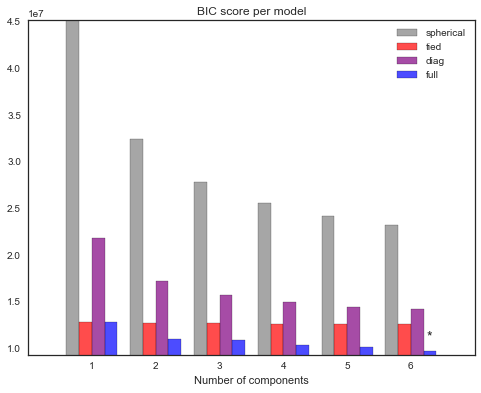

Optimal number of mixture components: 6
BIC for optimal (6) component mix: 14362547.6192


In [15]:
opt_comp = select_gmm(X).n_components
print 'Optimal number of mixture components:', opt_comp

gmmo = mixture.GMM( n_components=opt_comp )

fit = gmmo.fit_predict(X)
mdf['comp'] = fit

print 'BIC for optimal ({}) component mix:'.format(opt_comp), gmmo.bic(X)

In [455]:
num_comps = 2
# num_comps = opt_comp

In [475]:
# 2-class GMM fit
gmm2 = mixture.GMM( n_components=num_comps )
fit2 = gmm2.fit_predict(X)

mdf['comp2'] = fit2
gmm2df = mdf.copy()

print 'BIC for 2-component mix:', gmm2.bic(X)

BIC for 2-component mix: 17278629.4757


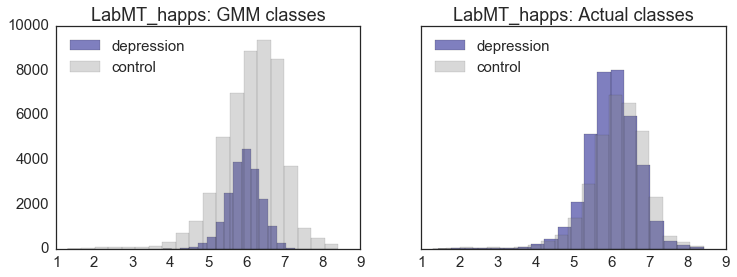

In [489]:
# are GMM classes aligned with actual classes on LabMT happiness scores?

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))

ax1.hist(gmm2df.LabMT_happs[gmm2df.comp2==1], color='navy', alpha=0.5, bins=20, label=condition)
ax1.hist(gmm2df.LabMT_happs[gmm2df.comp2==0], color='gray', alpha=0.3, bins=20, label='control')
ax1.set_title('LabMT_happs: GMM classes')
ax1.legend(loc='upper left')

ax2.hist(gmm2df.LabMT_happs[gmm2df.target==1], color='navy', alpha=0.5, bins=20, label=condition)
ax2.hist(gmm2df.LabMT_happs[gmm2df.target==0], color='gray', alpha=0.3, bins=20, label='control')
ax2.set_title('LabMT_happs: Actual classes')
ax2.legend(loc='upper left')

Below we take the 2-class GMM case and compute F1 scores, and compare that to a resampling distribution of F1 scores generated by unweighted random guesses.

In [490]:
gmm2_acc = {}

actual_neg = gmm2df.target==0
preds = gmm2df.comp2
pred_neg = preds==0

tn = np.sum(actual_neg & pred_neg)
pneg = np.sum(pred_neg)
neg = np.sum(actual_neg)

gmm2_acc['npv'] = round( tn / float(pneg), 3)
gmm2_acc['specificity'] = round( tn / float(neg), 3 )
gmm2_acc['f1'] = round(f1_score(gmm2df.target, gmm2df.comp2, average='binary'), 3)
gmm2_acc['precision'] = round(precision_score(gmm2df.target, gmm2df.comp2, average='binary'), 3)
gmm2_acc['recall'] = round(recall_score(gmm2df.target, gmm2df.comp2, average='binary'), 3)

print
print 'Accuracy scores for 2-component GMM:'
print
for score in ['recall','precision','specificity','npv','f1']:
    print '{}:'.format(score), gmm2_acc[score]
    


Accuracy scores for 2-component GMM:

recall: 0.349
precision: 0.638
specificity: 0.778
npv: 0.517
f1: 0.452


In [491]:
np.sum(gmm2df.target==gmm2df.comp2)/float(gmm2df.shape[0])

0.55166707438159235

In [462]:
# how many samples of random unweighted guesses do we want?
gmm_perm_iter = 1000

In [493]:
guess_acc = {'f1':[],'specificity':[],'npv':[],'precision':[],'recall':[]}

for i in range(gmm_perm_iter):
    unweighted_guess = np.random.randint(0,2,gmm2df.shape[0])
    
    actual_neg = gmm2df.target==0
    preds = unweighted_guess
    pred_neg = preds==0

    tn = np.sum(actual_neg & pred_neg)
    pneg = np.sum(pred_neg)
    neg = np.sum(actual_neg)
    guess_acc['f1'].append(f1_score(gmm2df.target, unweighted_guess, average='binary'))
    guess_acc['npv'].append( round( tn / float(pneg), 3) )
    guess_acc['specificity'].append( round( tn / float(neg), 3 ) )
    guess_acc['precision'].append( round(precision_score(gmm2df.target, unweighted_guess, average='binary'), 3) )
    guess_acc['recall'].append( round(recall_score(gmm2df.target, unweighted_guess, average='binary'), 3) )
    
print
print 'Accuracy scores for random guessing (over {} rounds):'.format(gmm_perm_iter)
print
for score in ['recall','precision','specificity','npv','f1']:
    print '{}:'.format(score), round(np.mean(guess_acc[score]),3), '(SD={})'.format(round(np.std(guess_acc[score]),3))
    

#plt.figure(figsize=(8,4))
#_=plt.hist(guess_f1s, bins=100)
#plt.title('F1 score: GMM vs 1000x Unweighted guess sampling histogram', fontsize=14)
#plt.axvline(gmm2_acc['f1'], color='green', label='GMM F1', alpha=0.6)
#plt.xlim([0.45, 0.6])
#plt.xlabel('F1 score', fontsize=14)
#plt.ylabel('Frequency')
#plt.legend(loc='upper left', fontsize=12)


Accuracy scores for random guessing (over 1000 rounds):

recall: 0.5 (SD=0.003)
precision: 0.528 (SD=0.002)
specificity: 0.5 (SD=0.003)
npv: 0.472 (SD=0.002)
f1: 0.514 (SD=0.002)


## HMM

Using hmmlearn module  

Specifies a two-state Hidden Markov Model, generates probabilities of each observation belonging to class 0/1.  
  
We look at the mean differences between variables and note they are similar to the mean differences between depressed and target classes...seems reasonable to infer that HMM is picking up on mood of some kind as a distinguisher.  

We show that depressed observations had a higher probability of being depressed, much before diagnosis.

In [251]:
# sort data by user and then by posting chronology
Xord = mdf.sort_values(['user_id','created_date']).copy()

# HMM needs to know how many posts are in the chronology for each user
# NB: 'total_words' here is not special, we can use any column that count() turns into a count vector.
lengths = Xord.groupby('user_id').count()['total_words'].values

In [252]:
# see Working with Multiple Sequences for more on the lengths argument
# http://hmmlearn.readthedocs.io/en/latest/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states

hmm = GaussianHMM(n_components=2).fit( Xord[predictors], lengths )

probas = hmm.predict_proba( Xord[predictors] )

In [253]:
Xord['proba0'] = probas[:,0]
Xord['proba1'] = probas[:,1]

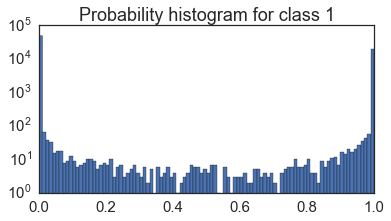

In [444]:
which_prob = 1

plt.figure(figsize=(6,3))
_=plt.hist(probas[:,which_prob], bins=100)
plt.yscale('log')
plt.title('Probability histogram for class {}'.format(which_prob))

In [441]:
#means[0:5]
#0: total_words
#1: LIWC_num_words
#2: LIWC_happs
#3: LabMT_num_words
#4: LabMT_happs

hmm_diff = pd.DataFrame(np.array([xrange(Xord[predictors].columns.shape[0]), 
                                  np.zeros(Xord[predictors].shape[1])]    ).T, 
                        index = Xord[predictors].columns, 
                        columns = ['col_idx','Class1-Class2'])
hmm_diff.col_idx = hmm_diff.col_idx.astype(int)
hmm_diff = hmm_diff.apply(lambda x: np.array([int(x[0]), hmm.means_[1,x[0]] - hmm.means_[0,x[0]]]), axis=1)
hmm_diff = pd.DataFrame(hmm_diff)

print 'Top 6 cases where Class 1 < Class 2'
print
hmm_diff.sort_values('Class1-Class2', ascending=True).iloc[0:6]

Top 6 cases where Class 1 < Class 2



/Users/andrew/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,col_idx,Class1-Class2
LabMT_happs,4.0,-0.192245
ANEW_happs,6.0,-0.155071
has_url,75.0,-0.111816
ANEW_dominance,8.0,-0.057012
LIWC_happs,2.0,-0.041980
ANEW_arousal,7.0,-0.037768


In [395]:
# check if Kalman means are different between target/control

a = hmm.means_[0,4] 
b = hmm.means_[0,4] 

test = ttest(a, b)


print 'Depressed HMM LabMT_happs mean: {} (sd={})'.format(round(a.mean(), 3), round(a.std(), 3))
print 'Control HMM LabMT_happs mean: {} (sd={})'.format(round(b.mean(), 3), round(b.std(), 3))
print
print 't = {}, p = {}'.format(test.statistic,test.pvalue)


Depressed HMM LabMT_happs mean: 6.138 (sd=0.0)
Control HMM LabMT_happs mean: 6.138 (sd=0.0)

t = nan, p = nan


/Users/andrew/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [257]:
# This will change per run!  HMM is agnostic to class number assignment...

target_class = 1 

# check the mean happiness difference between classes to figure out which is which

In [348]:
key_var = 'proba1'
hmm_roll = 90

In [349]:

hmm_dff = Xord.reset_index(drop=True)
ct = 0
color_ct = 0
uct = 0
last_uid = ''
colors = ['blue','purple','green','orange','pink','maroon','cyan']

hmm_master_t = pd.DataFrame()

for idx in dff.ix[(hmm_dff.target==1) & hmm_dff[key_var].notnull(),:].index:

    
    uid = hmm_dff.ix[idx,'user_id']
    if uid != last_uid:
        ct += 1
        last_uid = uid
        diag = pd.to_datetime(hmm_dff.ix[idx,'diag_date'])
        hmm_oneuser = hmm_dff.ix[hmm_dff.user_id==uid, :].copy()

        ts = hmm_oneuser.ix[:,[key_var,'from_diag']].copy()
        ts['from_point'] = ts.from_diag
        ts.index = pd.to_datetime(hmm_oneuser.created_date)

        mask = (ts.index > diag-pd.DateOffset(365)) & (ts.index < diag+pd.DateOffset(365))
        #ts2 = ts.ix[mask,'kf_mean'].copy()
        ts['rmean'] = ts[key_var].rolling(hmm_roll).mean()
        ts2 = ts.loc[mask]
        hmm_master_t = pd.concat([hmm_master_t,ts2])
        #print ts2.head(20)
        #ax = ts.plot(style='-')
        #plt.plot(ts2.from_diag, ts2.proba1, colors[color_ct], alpha=0.3)
        #plt.axvline(x=0, color='red')
        #color_ct = ct % 4
        #plt.xlim([diag-pd.DateOffset(365), diag+pd.DateOffset(365)])
hmm_master_t[key_var].describe()

count    2.290600e+04
mean     3.322183e-01
std      4.693802e-01
min      8.030603e-67
25%      2.000224e-43
50%      1.727149e-27
75%      1.000000e+00
max      1.000000e+00
Name: proba1, dtype: float64

In [374]:
ct = 0
color_ct = 0
uct = 0
last_uid = ''
colors = ['blue','purple','green','orange','pink','maroon','cyan']

hmm_master_c = pd.DataFrame()

for idx in hmm_dff.ix[(hmm_dff.target==0) & hmm_dff[key_var].notnull(),:].index:

    uid = hmm_dff.ix[idx,'user_id']
    if uid != last_uid:
        ct += 1
        last_uid = uid
        current = pd.to_datetime('2016-04-01')

        hmm_oneuser = hmm_dff.ix[hmm_dff.user_id==uid, :].copy()

        ts = hmm_oneuser.ix[:,[key_var,'created_date','LabMT_happs']].copy()
        ts.index = pd.to_datetime(hmm_oneuser.created_date)
        ts['from_point'] = (ts.index-current).days
        mask = (ts.from_point > -365*2)

        ts['rmean'] = ts[key_var].rolling(hmm_roll).mean()
        ts2 = ts.loc[mask].copy()
        ts2.from_point = ts2.from_point + 365
        hmm_master_c = pd.concat([hmm_master_c, ts2])
        #print ts2.head(20)
        #ax = ts.plot(style='-')
        #plt.plot(ts2.from_current, ts2.rmean, colors[color_ct], alpha=0.3)
        #plt.axvline(x=0, color='red')
        #plt.ylim([-20,120])
        #color_ct = ct % 4
        #plt.xlim([diag-pd.DateOffset(365), diag+pd.DateOffset(365)])


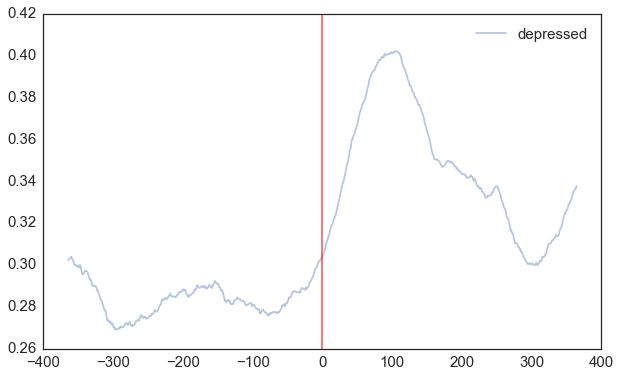

In [393]:
hmm_master_t['target'] = 'depressed'
hmm_master_c['target'] = 'control'
hmm_tsdf = pd.concat([hmm_master_t, hmm_master_c])

hmm_tsgb = hmm_tsdf.groupby(['target','from_point']).agg({'rmean':['mean','var'],
                                                          'LabMT_happs':'mean'})

new_colname = ['%s%s' % (a, '|%s' % b if b else '') for a, b in hmm_tsgb.columns]
hmm_tsgb.columns = new_colname

hmm_tsgb2 = hmm_tsgb.reset_index()

hmm_tsgb2['Probability depressed'] = hmm_tsgb2['rmean|mean'].rolling(hmm_roll).mean()

hmm_t_rm = hmm_tsgb2.ix[hmm_tsgb2.target=='depressed','Probability depressed']
hmm_t_from = hmm_tsgb2.ix[hmm_tsgb2.target=='depressed','from_point']

hmm_c_rm = hmm_tsgb2.ix[hmm_tsgb2.target=='control','Probability depressed']
hmm_c_from = hmm_tsgb2.ix[hmm_tsgb2.target=='control','from_point']

plt.figure(figsize=(10,6))
plt.plot(hmm_t_from,hmm_t_rm, alpha=.4, label='depressed')
#plt.xlim([-180, 60])
#plt.plot(c_from, c_rm, alpha=.4, label='control')
plt.axvline(x=0, color='red', alpha=0.6)
plt.legend()

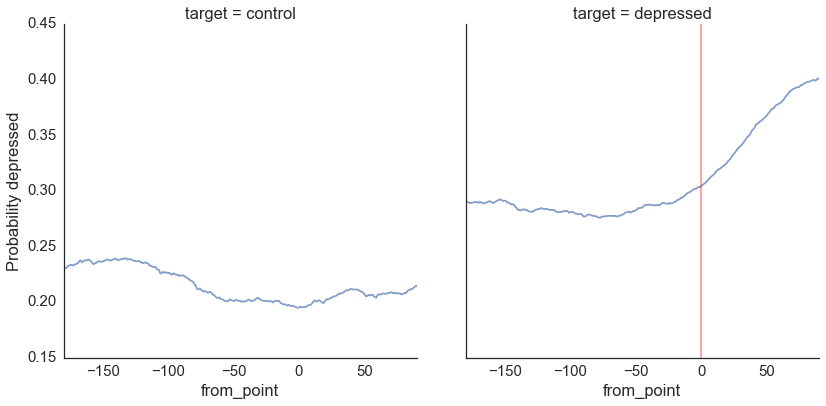

In [394]:
g = sns.FacetGrid(hmm_tsgb2, col='target', size=6)
g.map(plt.plot, 'from_point', 'Probability depressed', alpha=0.7)
g.axes[0,1].axvline(x=0, color='r', alpha=0.4)
g.set(xlim=(-180,90))
sns.set("notebook", font_scale=1.5, style='white')